<a href="https://colab.research.google.com/github/rounaksaha12/Graph-Clustering/blob/main/GNN_citations_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir graph_info

In [2]:
!mkdir outputs

In [3]:
!pip install scipy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 37.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [4]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.0/296.0 KB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 52.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric

1.13.0+cu116
11.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 77.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 26.4 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=f7a739c0241e4e5ae22656cd40b80de3b70d91f609dc13115dd4730b8b079dcb
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
S

In [1]:
import time
import numpy as np
import pandas as pd
import networkx as nx

In [2]:
intended_cluster_count=9 #choosing cluster count with highest silhoutte index

cluster_assignments_df=pd.read_csv(f'./outputs/cluster_assignments_ncluster_{intended_cluster_count}.csv')
cluster_labels=cluster_assignments_df.to_numpy()[:,1]
node_count=len(cluster_labels)
print(node_count)
print(cluster_labels)

2114
[2 7 3 ... 2 5 3]


In [3]:
mapped_edge_list=pd.read_csv('./graph_info/edge_info.txt',delimiter='\t').to_numpy()
mapped_edge_list

array([[   0,  140],
       [   1, 1630],
       [   2, 1038],
       ...,
       [2027, 2047],
       [2027, 2050],
       [2059, 2079]])

In [4]:
G_mapped=nx.Graph()
G_mapped.add_nodes_from(np.arange(node_count))
G_mapped.add_edges_from(mapped_edge_list)

In [5]:
print(G_mapped.number_of_nodes())
print(G_mapped.number_of_edges())

2114
2160


In [6]:
import torch
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T

In [7]:
adj = nx.to_scipy_sparse_array(G_mapped).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

In [8]:
# custom dataset
class CitationsDataset(InMemoryDataset):
    def __init__(self, G, edge_index, num_classes, cluster_labels,transform=None):
        super(CitationsDataset, self).__init__('.', transform, None, None)
        data = Data(edge_index=edge_index)
        n_nodes = G.number_of_nodes()
        data.num_nodes = n_nodes
        
        # input feature: node id
        data.x = torch.arange(n_nodes)
        
        # labels
        y = torch.from_numpy(cluster_labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = num_classes

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(list(G.nodes())), 
                                                            pd.Series(cluster_labels),
                                                            test_size=0.20, 
                                                            random_state=42)
        
        
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [10]:
num_classes=np.argmax(cluster_labels)+1
citations_data=CitationsDataset(G_mapped,edge_index,num_classes,cluster_labels)[0]
# print(citations_dataset)

Defining the network

In [11]:
class Net(nn.Module):
      def __init__(self,num_nodes,num_classes,embed_dim=32):
          super(Net,self).__init__()
          self.num_nodes=num_nodes
          self.embed_dim=embed_dim
          self.embed=nn.Embedding(num_nodes,embed_dim)
          self.conv1=GCNConv(embed_dim,64)
          self.conv2=GCNConv(64,int(num_classes))

      def forward(self,x,edge_index):
          x=self.embed(x)
          x=F.relu(self.conv1(x,edge_index))
          x = F.dropout(x, training=self.training)
          x = self.conv2(x, edge_index)
          return F.log_softmax(x, dim=1)

      def decode(self,x,edge_index):
          x=F.relu(self.conv1(x,edge_index))
          x = F.dropout(x, training=self.training)
          x = self.conv2(x, edge_index)
          return F.log_softmax(x, dim=1)



In [12]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
citations_data=citations_data.to(device)
model=Net(node_count,num_classes,2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2, weight_decay=5e-4)

In [13]:
from tqdm import tqdm

Training

In [14]:
epoch_cnt=500

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

t_start = time.time()

# train loop
for epoch in tqdm(range(epoch_cnt)):
    t = time.time()

    model.train()
    optimizer.zero_grad()
    
    output = model(citations_data.x,edge_index)
    loss_train = F.nll_loss(output[citations_data.train_mask], citations_data.y[citations_data.train_mask])
    acc_train = accuracy(output[citations_data.train_mask], citations_data.y[citations_data.train_mask])
    
    loss_train.backward()
    
    optimizer.step()
    
    model.eval()
    output = model(citations_data.x,edge_index)
    
    loss_val = F.nll_loss(output[citations_data.test_mask], citations_data.y[citations_data.test_mask])
    acc_val = accuracy(output[citations_data.test_mask], citations_data.y[citations_data.test_mask])
    
    if not epoch % 10:
      # Print all the results and the time required
      print('Epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'acc_train: {:.4f}'.format(acc_train.item()),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'acc_val: {:.4f}'.format(acc_val.item()),
            'time: {:.4f}s'.format(time.time() - t))
    
print("Model training is complete!")
print("Total model training time: {:.4f}s".format(time.time() - t_start))

  1%|▏         | 7/500 [00:00<00:18, 26.45it/s]

Epoch: 0001 loss_train: 2.4955 acc_train: 0.0852 loss_val: 2.4602 acc_val: 0.1253 time: 0.1984s
Epoch: 0011

  3%|▎         | 17/500 [00:00<00:12, 38.13it/s]

 loss_train: 2.2670 acc_train: 0.1892 loss_val: 2.2784 acc_val: 0.1844 time: 0.0189s


  6%|▌         | 28/500 [00:00<00:10, 45.07it/s]

Epoch: 0021 loss_train: 2.1565 acc_train: 0.2052 loss_val: 2.1836 acc_val: 0.1986 time: 0.0201s
Epoch: 0031 loss_train: 2.0426 acc_train: 0.2383 loss_val: 2.0766 acc_val: 0.2317 time: 0.0179s


 10%|▉         | 48/500 [00:01<00:09, 46.14it/s]

Epoch: 0041 loss_train: 1.8725 acc_train: 0.3146 loss_val: 1.9043 acc_val: 0.3050 time: 0.0180s


 12%|█▏        | 58/500 [00:01<00:09, 45.61it/s]

Epoch: 0051 loss_train: 1.5924 acc_train: 0.4276 loss_val: 1.6459 acc_val: 0.4421 time: 0.0199s


 14%|█▎        | 68/500 [00:01<00:09, 45.76it/s]

Epoch: 0061 loss_train: 1.2855 acc_train: 0.5677 loss_val: 1.3448 acc_val: 0.5603 time: 0.0225s


 16%|█▌        | 78/500 [00:01<00:09, 45.51it/s]

Epoch: 0071 loss_train: 0.9758 acc_train: 0.6765 loss_val: 1.0618 acc_val: 0.6643 time: 0.0251s


 18%|█▊        | 88/500 [00:02<00:08, 47.25it/s]

Epoch: 0081 loss_train: 0.7604 acc_train: 0.7700 loss_val: 0.8276 acc_val: 0.7541 time: 0.0217s


 20%|█▉        | 98/500 [00:02<00:08, 47.06it/s]

Epoch: 0091 loss_train: 0.5308 acc_train: 0.8415 loss_val: 0.6602 acc_val: 0.8109 time: 0.0227s


 22%|██▏       | 108/500 [00:02<00:08, 46.70it/s]

Epoch: 0101 loss_train: 0.3950 acc_train: 0.9007 loss_val: 0.5425 acc_val: 0.8511 time: 0.0224s


 24%|██▎       | 118/500 [00:02<00:08, 45.56it/s]

Epoch: 0111 loss_train: 0.2897 acc_train: 0.9296 loss_val: 0.4693 acc_val: 0.8605 time: 0.0220s


 26%|██▌       | 128/500 [00:02<00:08, 46.31it/s]

Epoch: 0121 loss_train: 0.2123 acc_train: 0.9539 loss_val: 0.4241 acc_val: 0.8771 time: 0.0203s


 28%|██▊       | 139/500 [00:03<00:07, 47.88it/s]

Epoch: 0131 loss_train: 0.1772 acc_train: 0.9675 loss_val: 0.3911 acc_val: 0.8771 time: 0.0214s


 30%|██▉       | 149/500 [00:03<00:07, 46.80it/s]

Epoch: 0141 loss_train: 0.1428 acc_train: 0.9781 loss_val: 0.3655 acc_val: 0.8913 time: 0.0257s


 32%|███▏      | 160/500 [00:03<00:07, 47.60it/s]

Epoch: 0151 loss_train: 0.1206 acc_train: 0.9805 loss_val: 0.3495 acc_val: 0.8936 time: 0.0227s


 33%|███▎      | 165/500 [00:03<00:07, 45.54it/s]

Epoch: 0161 loss_train: 0.1019 acc_train: 0.9846 loss_val: 0.3287 acc_val: 0.9007 time: 0.0246s


 35%|███▌      | 177/500 [00:03<00:06, 48.16it/s]

Epoch: 0171 loss_train: 0.0927 acc_train: 0.9917 loss_val: 0.3113 acc_val: 0.9007 time: 0.0213s
Epoch: 0181 loss_train: 0.0834 acc_train: 0.9947 

 37%|███▋      | 187/500 [00:04<00:06, 48.08it/s]

loss_val: 0.2928 acc_val: 0.9125 time: 0.0180s


 39%|███▉      | 197/500 [00:04<00:06, 47.90it/s]

Epoch: 0191 loss_train: 0.0780 acc_train: 0.9935 loss_val: 0.2758 acc_val: 0.9196 time: 0.0240s


 42%|████▏     | 208/500 [00:04<00:06, 48.14it/s]

Epoch: 0201 loss_train: 0.0708 acc_train: 0.9935 loss_val: 0.2593 acc_val: 0.9243 time: 0.0238s


 44%|████▎     | 218/500 [00:04<00:06, 46.55it/s]

Epoch: 0211 loss_train: 0.0625 acc_train: 0.9947 loss_val: 0.2419 acc_val: 0.9314 time: 0.0201s


 46%|████▌     | 229/500 [00:05<00:05, 48.25it/s]

Epoch: 0221 loss_train: 0.0615 acc_train: 0.9970 loss_val: 0.2319 acc_val: 0.9338 time: 0.0204s
Epoch: 0231 loss_train: 0.0580 acc_train: 0.9970 loss_val: 0.2140 acc_val: 0.9456 time: 0.0175s


 50%|████▉     | 249/500 [00:05<00:05, 48.17it/s]

Epoch: 0241 loss_train: 0.0593 acc_train: 0.9976 loss_val: 0.1995 acc_val: 0.9504 time: 0.0193s


 52%|█████▏    | 259/500 [00:05<00:05, 48.09it/s]

Epoch: 0251 loss_train: 0.0526 acc_train: 0.9982 loss_val: 0.1816 acc_val: 0.9527 time: 0.0200s


 54%|█████▍    | 270/500 [00:05<00:04, 48.06it/s]

Epoch: 0261 loss_train: 0.0537 acc_train: 0.9965 loss_val: 0.1685 acc_val: 0.9574 time: 0.0280s


 56%|█████▌    | 280/500 [00:06<00:04, 47.66it/s]

Epoch: 0271 loss_train: 0.0501 acc_train: 0.9982 loss_val: 0.1621 acc_val: 0.9622 time: 0.0230s


 57%|█████▋    | 285/500 [00:06<00:04, 44.70it/s]

Epoch: 0281 loss_train: 0.0556 acc_train: 0.9970 loss_val: 0.1512 acc_val: 0.9645 time: 0.0252s


 60%|██████    | 300/500 [00:06<00:04, 46.62it/s]

Epoch: 0291 loss_train: 0.0481 acc_train: 0.9994 loss_val: 0.1437 acc_val: 0.9716 time: 0.0216s


 62%|██████▏   | 310/500 [00:06<00:04, 45.97it/s]

Epoch: 0301 loss_train: 0.0561 acc_train: 0.9941 loss_val: 0.1347 acc_val: 0.9740 time: 0.0247s


 64%|██████▍   | 320/500 [00:06<00:03, 47.25it/s]

Epoch: 0311 loss_train: 0.0517 acc_train: 0.9970 loss_val: 0.1279 acc_val: 0.9764 time: 0.0239s


 66%|██████▌   | 330/500 [00:07<00:03, 47.02it/s]

Epoch: 0321 loss_train: 0.0486 acc_train: 0.9994 loss_val: 0.1279 acc_val: 0.9787 time: 0.0242s


 67%|██████▋   | 335/500 [00:07<00:03, 46.17it/s]

Epoch: 0331 loss_train: 0.0434 acc_train: 1.0000 loss_val: 0.1188 acc_val: 0.9811 time: 0.0248s


 69%|██████▉   | 346/500 [00:07<00:03, 47.34it/s]

Epoch: 0341 loss_train: 0.0472 acc_train: 0.9982 loss_val: 0.1138 acc_val: 0.9811 time: 0.0219s


 71%|███████   | 356/500 [00:07<00:03, 47.60it/s]

Epoch: 0351 loss_train: 0.0453 acc_train: 0.9982 loss_val: 0.1085 acc_val: 0.9858 time: 0.0212s


 73%|███████▎  | 367/500 [00:07<00:02, 48.08it/s]

Epoch: 0361 loss_train: 0.0481 acc_train: 0.9988 loss_val: 0.1057 acc_val: 0.9882 time: 0.0216s


 76%|███████▌  | 378/500 [00:08<00:02, 48.56it/s]

Epoch: 0371 loss_train: 0.0392 acc_train: 0.9994 loss_val: 0.1086 acc_val: 0.9858 time: 0.0237s
Epoch: 0381 loss_train: 0.0379 acc_train: 0.9994 loss_val: 0.1029 acc_val: 0.9858 time: 0.0183s


 80%|████████  | 400/500 [00:08<00:02, 48.97it/s]

Epoch: 0391 loss_train: 0.0459 acc_train: 0.9994 loss_val: 0.1008 acc_val: 0.9882 time: 0.0200s


 82%|████████▏ | 410/500 [00:08<00:01, 47.41it/s]

Epoch: 0401 loss_train: 0.0454 acc_train: 1.0000 loss_val: 0.0944 acc_val: 0.9882 time: 0.0263s


 84%|████████▍ | 421/500 [00:09<00:01, 48.47it/s]

Epoch: 0411 loss_train: 0.0438 acc_train: 0.9994 loss_val: 0.0996 acc_val: 0.9882 time: 0.0254s
Epoch: 0421 loss_train: 0.0445 acc_train: 1.0000 loss_val: 0.0998 acc_val: 0.9882 time: 0.0182s


 87%|████████▋ | 436/500 [00:09<00:01, 46.86it/s]

Epoch: 0431 loss_train: 0.0428 acc_train: 0.9988 loss_val: 0.0948 acc_val: 0.9905 time: 0.0208s


 89%|████████▉ | 446/500 [00:09<00:01, 46.99it/s]

Epoch: 0441 loss_train: 0.0424 acc_train: 0.9994 loss_val: 0.0941 acc_val: 0.9882 time: 0.0222s


 91%|█████████ | 456/500 [00:09<00:00, 45.89it/s]

Epoch: 0451 loss_train: 0.0414 acc_train: 0.9994 loss_val: 0.0936 acc_val: 0.9882 time: 0.0222s


 93%|█████████▎| 466/500 [00:10<00:00, 46.15it/s]

Epoch: 0461 loss_train: 0.0453 acc_train: 0.9982 loss_val: 0.0914 acc_val: 0.9905 time: 0.0219s


 95%|█████████▌| 477/500 [00:10<00:00, 47.95it/s]

Epoch: 0471 loss_train: 0.0418 acc_train: 0.9994 loss_val: 0.0932 acc_val: 0.9905 time: 0.0230s


 97%|█████████▋| 487/500 [00:10<00:00, 47.06it/s]

Epoch: 0481 loss_train: 0.0424 acc_train: 0.9988 loss_val: 0.0923 acc_val: 0.9882 time: 0.0220s


100%|██████████| 500/500 [00:10<00:00, 46.41it/s]

Epoch: 0491 loss_train: 0.0402 acc_train: 1.0000 loss_val: 0.0933 acc_val: 0.9905 time: 0.0242s
Model training is complete!
Total model training time: 10.7827s


Plotting the embedding space

Parameter containing:
tensor([[-0.2450, -0.1919],
        [-0.1321,  0.2692],
        [ 0.1151,  0.2090],
        ...,
        [-0.0951, -0.0605],
        [ 0.3422,  0.1134],
        [ 0.1010,  0.2289]], requires_grad=True)


100%|██████████| 500/500 [23:48<00:00,  2.86s/it]


[[4. 4. 4. ... 7. 7. 7.]
 [4. 4. 4. ... 7. 7. 7.]
 [4. 4. 4. ... 7. 7. 7.]
 ...
 [6. 6. 6. ... 3. 3. 3.]
 [6. 6. 6. ... 3. 3. 3.]
 [6. 6. 6. ... 3. 3. 3.]]


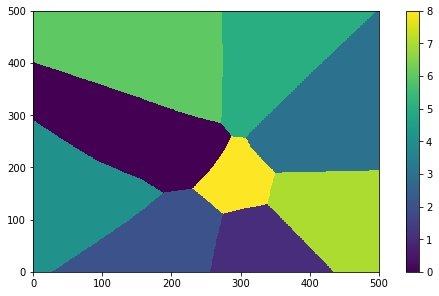

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_examples(color_mat,colormaps):
    """
    Helper function to plot color_mat with associated colormap.
    """    
    fig, axs = plt.subplots(constrained_layout=True, squeeze=False)
    ax=axs.flat[0]
    cmap=colormaps
    psm = ax.pcolormesh(color_mat, cmap=cmap, rasterized=True, vmin=0, vmax=8)
    fig.colorbar(psm, ax=ax)
    plt.savefig('graph.jpeg')

for embedding_mat in model.embed.parameters():
  print(embedding_mat)
  max_x=torch.max(embedding_mat[:,0]).detach()
  min_x=torch.min(embedding_mat[:,0]).detach()
  max_y=torch.max(embedding_mat[:,1]).detach()
  min_y=torch.min(embedding_mat[:,1]).detach()

grid_size=500
x_step=(max_x-min_x)/grid_size
y_step=(max_y-min_y)/grid_size
color_mat=np.empty((grid_size,grid_size))


for i in tqdm(range(grid_size)):
  for j in range(grid_size):
    emb_x=min_x+x_step*i
    emb_y=min_y+y_step*j
    dummy_input=torch.zeros((node_count,2),dtype=torch.float32)
    dummy_input[0][0]=emb_x
    dummy_input[0][1]=emb_y
    color_mat[i][j]=torch.argmax(model.decode(dummy_input,edge_index)[0]).item()

print(color_mat)

viridis = mpl.colormaps['viridis'].resampled(256)
plot_examples(color_mat,viridis)